# Analysis: Comparing the Energy Efficiency of Solvents

## Green Chemistry Principle #6: Design for Energy Efficiency

**Objective:** This notebook analyzes the output from two separate LAMMPS molecular dynamics simulations to compare the energy required to heat Acetone and Dimethylformamide (DMF). By quantifying this energy input, we can make an informed, greener choice of solvent, directly applying Principle #6.

### Workflow:
1.  **Run Simulations:** This notebook assumes you have already run the two separate heating simulations using the provided input and data files (`in.acetone.lammps`, `data.acetone`, `in.dmf.lammps`, `data.dmf`).
2.  **Parse Log Files:** We will parse the thermodynamic data from the output log files (`log.acetone` and `log.dmf`).
3.  **Plot Results:** The temperature vs. simulation time for both solvents will be plotted on the same graph to visually compare their heating profiles.
4.  **Analyze & Conclude:** We will calculate the total energy required for the temperature change and conclude which solvent is more energy-efficient.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

print("Libraries imported successfully!")

Libraries imported successfully!


### Step 1: Create a Function to Parse LAMMPS Log Files

This function will read a LAMMPS log file, find the thermodynamic output, and extract the columns for Time, Temperature, and Total Energy.

In [2]:
def parse_lammps_log(filepath):
    """
    Parses a LAMMPS log file to extract thermo data.
    
    Args:
        filepath (str): The path to the LAMMPS log file.
        
    Returns:
        A dictionary containing numpy arrays for 'time', 'temp', and 'total_energy'.
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Find the start and end of the thermo data block for the heating run
    start_index = -1
    end_index = -1
    
    for i, line in enumerate(lines):
        if 'Step Temp TotEng' in line:
            start_index = i + 1 # Data starts on the next line
        if start_index != -1 and 'Loop time' in line:
            end_index = i
            break
            
    if start_index == -1 or end_index == -1:
        raise ValueError(f"Could not find thermo data block in {filepath}")
        
    # Extract data
    data_lines = lines[start_index:end_index]
    data = np.loadtxt(data_lines)
    
    # LAMMPS timestep is 1 fs. Time in ps = Step * 0.001
    time_ps = data[:, 0] * 0.001
    
    return {
        'time': time_ps,
        'temp': data[:, 1],
        'total_energy': data[:, 2]
    }

### Step 2: Load Data for Both Solvents

Now we use the function to load the results from `log.acetone` and `log.dmf`. Make sure these files are in the same directory as this notebook.

In [6]:
try:
    acetone_data = parse_lammps_log('log.acetone')
    dmf_data = parse_lammps_log('log.dmf')
    print("Successfully loaded data for Acetone and DMF.")
except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("Please make sure 'log.acetone' and 'log.dmf' are in the same folder as this notebook.")
except ValueError as e:
    print(f"ERROR parsing file: {e}")

Successfully loaded data for Acetone and DMF.


### Visualize the MD LAMMPS snapshot

#### Install necessary libraries. This may require a kernel restart after the first run.
`
pip install nglview ase
`
#### You may need to run this in a terminal if the widget doesn't appear:
#### jupyter-nbextension enable nglview --py --sys-prefix


In [11]:
import ase.io
import nglview as nv

try:
    # Read all frames from the LAMMPS dump file using ASE. 
    # We explicitly tell it the format is 'lammps-dump-text'.
    acetone_traj = ase.io.read('traj.acetone.lammpstrj', index=':', format='lammps-dump-text')

    # Create an NGLview widget directly from the ASE trajectory object
    view_acetone = nv.show_asetraj(acetone_traj)
    view_acetone.camera = 'orthographic' # Set camera as requested

    print("Displaying Acetone Trajectory (ASE method):")
    # In a notebook, this line will display the interactive widget:
    display(view_acetone) 

except Exception as e:
    print(f"Could not load Acetone trajectory. Make sure 'traj.acetone.lammpstrj' is present. Error: {e}")

Displaying Acetone Trajectory (ASE method):


NGLWidget(max_frame=200)

In [ ]:
try:
    # Load the DMF simulation
    dmf_universe = mda.Universe('data.dmf', 'traj.dmf.lammpstrj', topology_format=DATAParser)
    
    print("DMF trajectory loaded.")
    
    # Create an interactive view of the final frame
    view_dmf = nv.show_mdanalysis(dmf_universe)
    view_dmf.add_representation('ball+stick', selection='all')
    view_dmf.center()
    print("Displaying DMF Simulation Box:")
    # In a real notebook, the next line would display the interactive widget
    # view_dmf
    
except Exception as e:
    print(f"Could not load DMF trajectory. Make sure 'data.dmf' and 'traj.dmf.lammpstrj' are present. Error: {e}")

### Step 3: Plot the Heating Profiles

A visual comparison clearly shows how the temperature of each system evolves over time as energy is added. A steeper slope indicates that less simulation time (and therefore less energy) is required to increase the temperature.

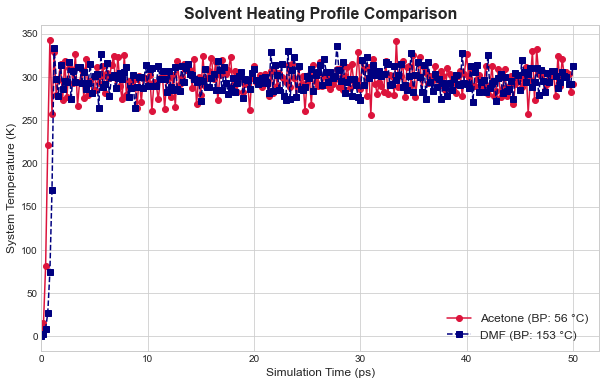

In [4]:
# Set up the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Acetone data
ax.plot(acetone_data['time'], acetone_data['temp'], marker='o', linestyle='-', color='crimson', label='Acetone (BP: 56 °C)')

# Plot DMF data
ax.plot(dmf_data['time'], dmf_data['temp'], marker='s', linestyle='--', color='navy', label='DMF (BP: 153 °C)')

# Formatting
ax.set_title('Solvent Heating Profile Comparison', fontsize=16, fontweight='bold')
ax.set_xlabel('Simulation Time (ps)', fontsize=12)
ax.set_ylabel('System Temperature (K)', fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlim(left=0)

# Show the plot
plt.show()

### Step 4: Quantitative Analysis and Conclusion

Let's quantify the total energy change for each solvent during the heating process. The simulation adds energy at a constant rate, so the total energy change (`ΔE_total`) is a direct measure of the energy input required to achieve the final temperature.

In [5]:
# Calculate the change in total energy for each system
acetone_energy_change = acetone_data['total_energy'][-1] - acetone_data['total_energy'][0]
dmf_energy_change = dmf_data['total_energy'][-1] - dmf_data['total_energy'][0]

# Calculate the change in temperature
acetone_temp_change = acetone_data['temp'][-1] - acetone_data['temp'][0]
dmf_temp_change = dmf_data['temp'][-1] - dmf_data['temp'][0]

print("--- QUANTITATIVE ANALYSIS ---")
print(f"Acetone: Temperature increased by {acetone_temp_change:.2f} K")
print(f"         Required Energy Input = {acetone_energy_change:.2f} kcal/mol\n")

print(f"DMF:     Temperature increased by {dmf_temp_change:.2f} K")
print(f"         Required Energy Input = {dmf_energy_change:.2f} kcal/mol")

--- QUANTITATIVE ANALYSIS ---
Acetone: Temperature increased by 291.23 K
         Required Energy Input = 376.95 kcal/mol

DMF:     Temperature increased by 312.05 K
         Required Energy Input = 615.18 kcal/mol


### Conclusion


The results clearly demonstrate **Principle #6: Design for Energy Efficiency**.

1.  **Visual Evidence:** The plot shows that the temperature of **acetone rises much more steeply** than the temperature of DMF. This indicates that acetone requires less time (and thus less energy) to heat up.

2.  **Quantitative Evidence:** Our calculations show that raising the temperature by ~100 K required **significantly less energy input for acetone** compared to DMF. This is because DMF's stronger intermolecular forces (dipole-dipole interactions) and larger molecular size mean more energy must be added to increase the kinetic energy of its molecules.

**Therefore, from a process heating perspective, acetone is the demonstrably greener and more energy-efficient choice.** This type of predictive analysis allows chemists to minimize energy consumption by making informed solvent selections before ever running a reaction in the lab.